In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy import polyfit, polyval

import info_measures.numpy.kraskov_stoegbauer_grassberger as ksg

In [2]:
variance = 1.
rho = .6
cs = {'knn1': '#9467bd',
      'knn2': '#8c564b',
      'true': '#1f77b4'}

In [3]:
def entropy(dim, variance, rho):
    e0 = variance*(1.+(dim-1.)*rho)
    return .5*np.log(e0 * np.power(variance*(1.-rho), dim-1)*(2.*np.pi*np.e)**dim)

def pi(dim, variance, rho):
    num = variance*(1.+(dim-1.)*rho)
    den = variance*(1.+(2*dim-1.)*rho)
    return np.log(num / np.sqrt(den)) -.5*np.log(variance*(1.-rho))

def pi_a(dim0, dim1, variance, rho):
    return entropy(dim0, variance, rho) + entropy(dim1, variance, rho)-entropy(dim0+dim1, variance, rho)

In [4]:
dims = np.linspace(1, 10, 4, dtype=int)
n_samples = np.logspace(1, 4, 4, dtype=int)
n_repeat = 100

e_ts = np.zeros((n_repeat, dims.size, n_samples.size))
e_2ts = np.zeros((n_repeat, dims.size, n_samples.size))
pis = np.zeros((n_repeat, dims.size, n_samples.size))
e_pi1s = np.zeros((n_repeat, dims.size, n_samples.size))
e_pi2s = np.zeros((n_repeat, dims.size, n_samples.size))

for ii in range(n_repeat):
    dim = dims[-1]
    sigma_2t = np.ones((2*dim, 2*dim)) * variance * rho
    sigma_2t[np.arange(2*dim), np.arange(2*dim)] = variance
    mean_2t = np.zeros(2*dim)
    samples = np.random.multivariate_normal(mean_2t, sigma_2t, size=n_samples[-1])
    samples_x = samples[:, :dim]
    samples_y = samples[:, dim:]
    for jj, dim in enumerate(dims):
        for kk, ns in enumerate(n_samples):
            sxi = samples_x[:ns, :dim]
            syi = samples_y[:ns, :dim]

#            e_t = entropy(dim, variance, rho)
#            e_2t = entropy(2*dim, variance, rho)
#            e_ts[ii, jj] = e_t
#            e_2ts[ii, jj] = e_2t
            pis[ii, jj, kk] = pi(dim, variance, rho)
            e_ksg = ksg.MutualInformation(sxi, syi)
            e_pi1s[ii, jj, kk] = e_ksg.mutual_information()

            e_pi2s[ii, jj, kk] = e_ksg.mutual_information(kind=2)

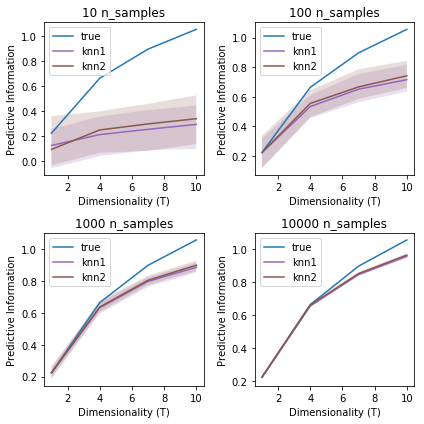

In [12]:
f, axes = plt.subplots(2, 2, figsize=(6, 6))
for kk, (ns, ax) in enumerate(zip(n_samples, axes.ravel())):
    ax.set_title('{} n_samples'.format(ns))
    for x, name in zip([pis, e_pi1s, e_pi2s], ['true', 'knn1', 'knn2']):
        label = name
        ax.plot(dims, np.median(x, axis=0)[:,kk], label=label, c=cs[name])
        if name != 'true':
            ax.fill_between(dims, np.percentile(x, 15.865, axis=0)[:,kk], np.percentile(x, 84.135, axis=0)[:,kk],
                             facecolor=cs[name], alpha=.2)
    ax.legend()
    ax.set_ylabel('Predictive Information')
    ax.set_xlabel('Dimensionality (T)')
f.tight_layout()
plt.savefig('/home/jesse/Downloads/pi_dim.pdf')
plt.show()

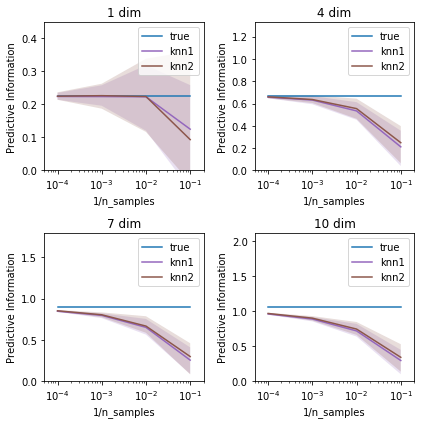

In [19]:
f, axes = plt.subplots(2, 2, figsize=(6, 6))
for kk, (dim, ax) in enumerate(zip(dims, axes.ravel())):
    ax.set_title('{} dim'.format(dim))
    for x, name in zip([pis, e_pi1s, e_pi2s], ['true', 'knn1', 'knn2']):
        xf = np.tile(1./n_samples[np.newaxis], (x.shape[0], 1))
        xf = np.concatenate([xf, -xf])
        yf = np.concatenate([x[:, kk], x[:, kk]])
        p = polyfit(xf.ravel(), yf.ravel(), deg=6)
        px = np.linspace(1./n_samples[-1], .1, 100)
        py = polyval(p, px)
        est = polyval(p, 0.)
        label = name
        #ax.plot(px, py, c='black', label='{} fit'.format(label))
        #ax.scatter(1./n_samples[-1], est)
        ax.plot(1./n_samples, np.median(x, axis=0)[kk], label=label, c=cs[name])
        if name != 'true':
            ax.fill_between(1./n_samples, np.percentile(x, 15.865, axis=0)[kk], np.percentile(x, 84.135, axis=0)[kk],
                             facecolor=cs[name], alpha=.2)
    ax.legend()
    ax.set_ylabel('Predictive Information')
    ax.set_xlabel('1/n_samples')
    ax.set_ylim(0, 2*pis[0,kk,0])
    ax.set_xlim(1./n_samples[-1]/2., 2./n_samples[0])
    ax.set_xscale('log')
f.tight_layout()
plt.savefig('/home/jesse/Downloads/pi_samples.pdf')
plt.show()

# Asymmetric PI

In [ ]:
variance = 1.
rho = .6

offset = 5
dims = np.arange(offset+1, 50)
dim0 = dims - offset
dim1 = dims + offset

In [ ]:
plt.plot(dims, pi(dims, variance, rho), label='symm')
plt.plot(dims, pi_a(dim0, dim1, variance, rho), label='asymm')
plt.xlabel('dimension')
plt.ylabel('Predictive Information')
plt.savefig('/home/jesse/Downloads/pi_asymm.pdf')
plt.show()